# **AI Talent Hackathon 2023: Кейс от X5 Group по созданию Customer Feedback Platform**

#Библиотеки

In [ ]:
# !pip install -q pymorphy2 # установка лемматизатора pymorphy2

In [1]:
from google.colab import files #для работы с файлами в Google Colab
from google.colab import drive #подключение Google-диска
import os #функционал для работы с операционной системой и файловой системой

import time #функционал для работы со временем
import datetime #функционал для работы с датами и временем

import pickle #для сохранения и загрузки tokenizer'а
from collections import Counter #для подсчёта повторений уникальных атрибутов

import tensorflow as tf
import keras as keras
import numpy as np
import pandas as pd
import re # Импортируем чтобы работать со строками
import matplotlib.pyplot as plt #для визуализации данных и диаграмм
import seaborn as sns #более высокоуровневый интерфейс для создания графиков
#команда для отображения графиков в блокнотах Jupyter и JupyterLab
%matplotlib inline

# import nltk #Natural language toolkit - Инструментарий естественного языка
# from nltk.stem import WordNetLemmatizer  # Импортируем для работы с леммами
# import pymorphy2 # Импортируем для работы с леммами

from keras.preprocessing.text import Tokenizer #для преобразования текстовых данных в числовые тензоры

from keras import utils #утилита для работы с нейронными сетями
from keras.utils import plot_model #графическое представление модели
from keras.models import Sequential, Model # для создания архитектур нейронных сетей
from keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation, Conv1D,  MaxPooling1D, Conv1DTranspose, GlobalMaxPooling1D #слои
from keras.layers import concatenate, Input, Reshape #слои
from keras.optimizers import Adam, Adadelta, SGD, Adagrad, RMSprop #оптимизаторы
from keras.models import load_model # для загрузки архитектур и весов нейронных сетей
from numpy.ma.core import append

In [2]:
# подключаем google-диск
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# функция звукового сигнала завершения выполнения кода
from google.colab import output #Для функции звукового сигнала выполнения ячейки
def beep(): #Функция звукового сигнала выполнения ячейки
  output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')
beep()

#Загрузка датасетов

In [101]:
id_address = pd.read_excel('/content/drive/MyDrive/hacaton_X5/database/shops_rates.xlsx', usecols=['id', 'address'])
shops_reviews = pd.read_excel('/content/drive/MyDrive/hacaton_X5/database/shops_reviews.xlsx')

In [100]:
id_address.head(10)

,id,address
0,189979809983,"Невский просп., 146, Нк1-, помещение 1"
1,74844042025,"ул. Декабристов, 14/7, этаж цокольный"
2,169305943267,"Манежная площадь, 6"
3,1639817005,"Владимирский просп., 6, этаж цокольный"
4,121166385794,"Литовская ул., 8, корп. 2"
5,46048034071,"Загородный просп., 35"
6,71049535978,"2-я линия Васильевского острова, 39/16"
7,93682651498,"Кирочная ул., 45, этаж цокольный"
8,1373623356,"Новочеркасский просп., 32, корп. 1"
9,167918656240,"просп. Римского-Корсакова, 55"


In [102]:
shops_reviews.head(10)

,rate,text,date,id
0,5,"Замечательный магазин. Всё чисто, цены соответ...",2023-04-23,189979809983
1,5,Очень хороший магазин и всегда отличный персон...,2023-08-11,189979809983
2,5,Были гостями город\nВот прям рекомендую!!! Отл...,2023-08-16,189979809983
3,5,Нравится как эволюционировала «Пятерочка» в по...,2023-07-19,189979809983
4,5,"Магазин хороший,чистый,удобный. Ассортимент до...",2023-06-17,189979809983
5,5,Составлять отзывы на сетевые магазины - дело м...,2023-04-17,189979809983
6,5,Как и большинство магазинов этой сети достаточ...,2023-08-02,189979809983
7,5,"Чисто, достаточно места, что не всегда бывает ...",2023-06-09,189979809983
8,4,"Пятёрочка очень понравилась, большой выбор тов...",2023-04-09,189979809983
9,5,"Персонал вежливый, ассортимент хороший, в часы...",2023-07-04,189979809983


Количество:
 5    16726
4     7431
3     4799
1     2880
2     1868
0       39
Name: rate, dtype: int64

Процентное соотношение:
 5    49.6
4    22.0
3    14.2
1     8.5
2     5.5
0     0.1
Name: rate, dtype: float64 %


<Axes: xlabel='rate', ylabel='count'>

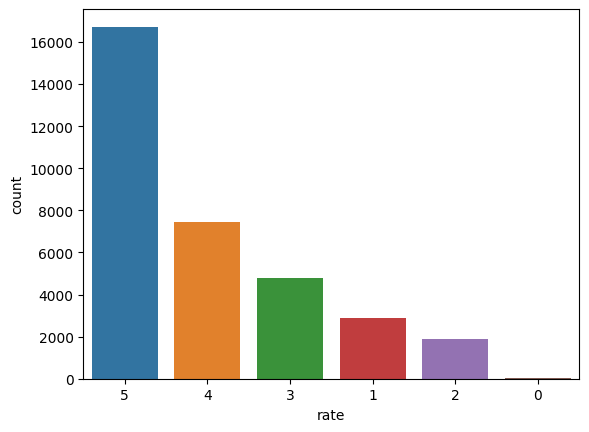

In [ ]:
print('Количество:\n', shops_reviews.rate.value_counts())
print('\nПроцентное соотношение:\n', round(shops_reviews.rate.value_counts(normalize=True) * 100, 1), '%')
sns.countplot(x = shops_reviews.rate, data = shops_reviews, order = shops_reviews.rate.value_counts().index)

Количество:
 1    1800
2    1800
3    1800
4    1800
5    1800
Name: rate, dtype: int64

Процентное соотношение:
 1    20.0
2    20.0
3    20.0
4    20.0
5    20.0
Name: rate, dtype: float64 %


<Axes: xlabel='rate', ylabel='count'>

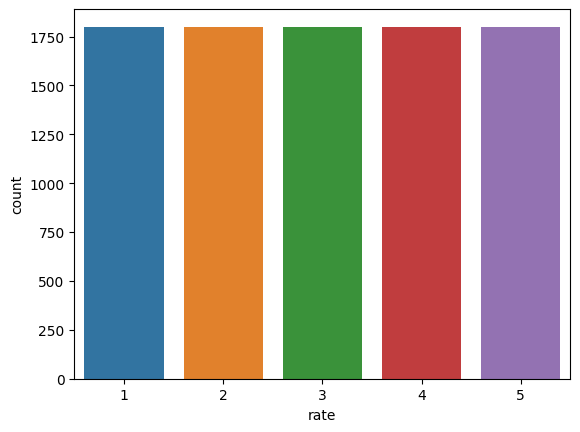

In [5]:
#Отбираем равное количество отзывов по рейтингу для обучения
vol_train_test = 1800

shops_reviews_train_test = pd.DataFrame()
for i in range(1,6):
  shops_reviews_i = shops_reviews[shops_reviews['rate'] == i]
  shops_reviews_train_test = pd.concat([shops_reviews_train_test, shops_reviews_i.head(vol_train_test)])

print('Количество:\n', shops_reviews_train_test.rate.value_counts())
print('\nПроцентное соотношение:\n', shops_reviews_train_test.rate.value_counts(normalize=True) * 100, '%')
sns.countplot(x = shops_reviews_train_test.rate, data = shops_reviews_train_test, order = shops_reviews_train_test.rate.value_counts().index)

Количество:
 1    68
2    68
3    68
4    68
5    68
Name: rate, dtype: int64

Процентное соотношение:
 1    20.0
2    20.0
3    20.0
4    20.0
5    20.0
Name: rate, dtype: float64 %


<Axes: xlabel='rate', ylabel='count'>

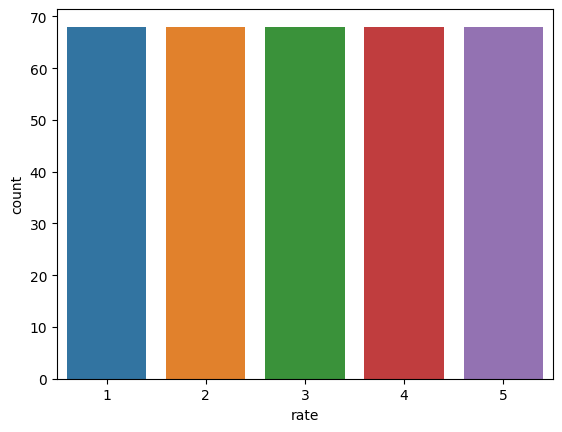

In [154]:
#Отбираем равное количество отзывов по рейтингу для валидации
vol_verif = 68

shops_reviews_verif = pd.DataFrame()
for i in range(1,6):
  shops_reviews_i = shops_reviews[shops_reviews['rate'] == i]
  shops_reviews_verif = pd.concat([shops_reviews_verif, shops_reviews_i.iloc[vol_train_test:vol_train_test+vol_verif]])

shops_reviews_verif.to_excel('/content/drive/MyDrive/hacaton_X5/output/shops_reviews_verif.xlsx')

print('Количество:\n', shops_reviews_verif.rate.value_counts())
print('\nПроцентное соотношение:\n', shops_reviews_verif.rate.value_counts(normalize=True) * 100, '%')
sns.countplot(x = shops_reviews_verif.rate, data = shops_reviews_verif, order = shops_reviews_verif.rate.value_counts().index)

#Tokenizer

In [10]:
# Собираем все тексты в один список для Tokenizer'а
allText = []
allText_str =''

for i in range(len(shops_reviews)):
  allText_str = allText_str + shops_reviews.text[i].replace('\n', '').replace("'", "")

allText.append(allText_str)

### на потом

In [ ]:
# Считываем текст из файла и удаляем пунктуационные знаки препинания и еще дополнительные ненужные нам знаки
def readText(fileName):
  # f = open(fileName, 'r') # Открываем наш файл и считываем наши данные
  # text = f.read() # Помещаем наш текст в переменную
  text = allText_0[0]
  # Определяем, какие знаки будут удалены
  delSymbols = ['\n', "\t", "\ufeff", ".", "_", "-", ",", "!", "?", "–", "(", ")", "«", "»", "№", ";",'•','%']

  for dS in delSymbols: # Каждый знак из нашего списка будет удалён из списка
    text = text.replace(dS, " ") # Удаляем знак, посредством замены этого знака на пробел

  # Выискиваем дополнительные знаки в текстах посредством паттернов и определяем на что их заменять
  text = re.sub("[.]", " ", text)
  text = re.sub(":", " ", text)
  text = re.sub("<", " <", text)
  text = re.sub(">", "> ", text)

  # split  метод разделит текст на последовательность слов при помощи пробелов
  # (а их может быть в одном месте очень много после наших удалений знаков), которые будет являться разделителями.
  # Используя join метод, мы обратно соберём последовательности слов в текст
  text = ' '.join(text.split())

  text = text.lower() # Конвертируем текст к нижнему регистру
  return text # Возвращаем текст

# Конвертируем исходный текст в лист слов с начальной формой
def text2Words(text):
  morph = pymorphy2.MorphAnalyzer() # Инициализируем инструмент для работы с морфемами и более
  words = text.split(' ') #  Разделяем текст по средством пробелов
  docs = [morph.parse(word)[0].normal_form for word in words] # Превращаем каждое слово в элемент списка
  return docs # Возвращаем полученный документ

In [ ]:
# Очищаем тексты от ненужных знаков
curTime = time.time() # Запоминаем текущее время
allText_0_clr = readText(allText_0)
print('Время обработки: ', round(time.time() - curTime, 2), 's.')

Превращение заняло:  0.22 s.


In [ ]:
# Лемматизация списка
curTime = time.time() # Запоминаем текущее время
allText = text2Words(allText_0_clr)
print('Время обработки: ', round(time.time() - curTime, 2), 's.')

Превращение заняло:  121.45 s.


###Токенизируем тексты

In [11]:
#################
# Преобразовываем текстовые данные в числовые/векторные для обучения нейросети
#################

maxWordsCount = 25000 # определяем макс.кол-во слов/индексов, учитываемое при обучении текстов
# для этого воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', char_level=False, oov_token = 'unknown')

# import string
# tokenizer = Tokenizer(num_words=maxWordsCount, filters=string.printable.replace('\n', '').replace('\t', '').replace('\r', '').replace('!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', ''), lower=True, split=' ', char_level=False, oov_token='unknown')

# выше задаем параметры:
# (num_words=maxWordsCount) - определяем макс.кол-во слов/индексов, учитываемое при обучении текстов
# (filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n') - избавляемся от ненужных символов
# (lower=True) - приводим слова к нижнему регистру
# (split=' ') - разделяем слова по пробелу
# (char_level=False) - просим токенайзер не удалять однобуквенные слова

# "скармливаем" наши тексты, т.е даём в обработку методу, который соберет словарь частотности
tokenizer.fit_on_texts(allText)

# Сохраняем файл tokenizer'а чтобы не ждать при каждом перезапуске ноута
with open('/content/drive/MyDrive/hacaton_X5/output/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

items = list(tokenizer.word_index.items()) #вытаскиваем индексы слов для просмотра
print('Размер токенайзера', len(items))
print(items[:100]) # взглянем на содержимое словаря

Размер токенайзера 43947
[('unknown', 1), ('и', 2), ('в', 3), ('не', 4), ('магазин', 5), ('на', 6), ('с', 7), ('что', 8), ('очень', 9), ('но', 10), ('есть', 11), ('все', 12), ('всегда', 13), ('как', 14), ('хороший', 15), ('по', 16), ('персонал', 17), ('ассортимент', 18), ('а', 19), ('то', 20), ('нет', 21), ('выбор', 22), ('большой', 23), ('за', 24), ('пятёрочка', 25), ('чисто', 26), ('это', 27), ('очереди', 28), ('из', 29), ('так', 30), ('всё', 31), ('кассы', 32), ('цены', 33), ('рядом', 34), ('для', 35), ('товар', 36), ('я', 37), ('товаров', 38), ('к', 39), ('много', 40), ('самообслуживания', 41), ('часто', 42), ('кассе', 43), ('магазине', 44), ('удобно', 45), ('только', 46), ('у', 47), ('продукты', 48), ('пятерочка', 49), ('можно', 50), ('магазина', 51), ('после', 52), ('мне', 53), ('товара', 54), ('от', 55), ('ценники', 56), ('если', 57), ('там', 58), ('бы', 59), ('продуктов', 60), ('кассиры', 61), ('работает', 62), ('акции', 63), ('вежливый', 64), ('постоянно', 65), ('товары', 66),

In [ ]:
print("Интересующее слово имеет индекс: ", tokenizer.word_index[input("Уточните слово: ")]) #протестируем словарь частотности

Уточните слово: хороший
Интересующее слово имеет индекс:  8


# Обучающая и тестовая выборки

In [12]:
# Делим shops_reviews_train_test на обучающую и тестовую выборки
cur_time = time.time() # Засекаем текущее время
vol_train = 1500

# Тексты
trainText_df = pd.DataFrame()
for i in range(1,6):
  shops_reviews_i = shops_reviews_train_test.text[shops_reviews_train_test['rate'] == i]
  trainText_df = pd.concat([trainText_df, shops_reviews_i.head(vol_train)])

testText_df = pd.DataFrame()
for i in range(1,6):
  shops_reviews_i = shops_reviews_train_test.text[shops_reviews_train_test['rate'] == i]
  testText_df = pd.concat([testText_df, shops_reviews_i.iloc[vol_train:]])

trainText = trainText_df[0].tolist()
testText = testText_df[0].tolist()

# #На потом - Очищаем отзыва от ненужных знаков
# trainText = []
# for i in range(len(trainText_noClr)):
#   trainText_clr = readText(trainText_noClr[i])
#   trainText.append(text2Words(trainText_clr))

# testText = []
# for i in range(len(testText_noClr)):
#   testText_clr = readText(testText_noClr[i])
#   testText.append(text2Words(testText_clr))

# Метки
trainRate_df = pd.DataFrame()
for i in range(1,6):
  shops_reviews_i = shops_reviews_train_test.rate[shops_reviews_train_test['rate'] == i]-1
  trainRate_df = pd.concat([trainRate_df, shops_reviews_i.head(vol_train)])

testRate_df = pd.DataFrame()
for i in range(1,6):
  shops_reviews_i = shops_reviews_train_test.rate[shops_reviews_train_test['rate'] == i]-1
  testRate_df = pd.concat([testRate_df, shops_reviews_i.iloc[vol_train:]])

trainRateArr = np.array(trainRate_df[0])
testRateArr = np.array(testRate_df[0])
print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep='')
beep()

Время обработки: 0.02c


In [ ]:
# #На потом - Очищаем отзыва от ненужных знаков
# shops_reviews_verif_noClr = shops_reviews_verif[0].tolist()

# verifText = []
# for i in range(len(shops_reviews_verif_noClr)):
#   shops_reviews_verif_clr = readText(shops_reviews_verif_noClr[i])
#   verifText.append(text2Words(shops_reviews_verif_clr))

# verifWordIndexes = tokenizer.texts_to_sequences(verifText)  # Проверочные тесты в индексы

# verif01 = np.empty((0, 25000)) # Обучающая
# for i in range(len(verifWordIndexes)):
#   arr_token = tokenizer.sequences_to_matrix(np.array([verifWordIndexes[i]]).tolist())
#   verif01 = np.concatenate((verif01, arr_token), axis=0)

In [13]:
# Преобразовываем текст в последовательность индексов согласно частотному словарю
trainWordIndexes = tokenizer.texts_to_sequences(trainText) # Обучающие тесты в индексы
testWordIndexes = tokenizer.texts_to_sequences(testText)  # Проверочные тесты в индексы

print("Взглянем на фрагмент обучающего текста:")
print("В виде оригинального текста:              ", trainText[1][1:87])
print("Он же в виде последовательности индексов: ", trainWordIndexes[1][:20], '\n')

Взглянем на фрагмент обучающего текста:
В виде оригинального текста:               дминистратор 14.06.2023 (без бейджа) неопрятного вида,  некомпетентный. Был задан вопр
Он же в виде последовательности индексов:  [569, 2014, 2545, 1548, 84, 3958, 14927, 1683, 6316, 141, 14928, 394, 437, 422, 3658, 3190, 6, 9850, 7, 1792] 



##xTrain и xTest в формате BOW

In [14]:
# Вектора one hot encoding обучающей и тестовой выборки
cur_time = time.time() # Засекаем текущее время

# Тексты
xTrain01 = np.empty((0, 25000)) # Обучающая
for i in range(len(trainWordIndexes)):
  arr_token = tokenizer.sequences_to_matrix(np.array([trainWordIndexes[i]]).tolist())
  xTrain01 = np.concatenate((xTrain01, arr_token), axis=0)

xTest01 = np.empty((0, 25000)) # Тестовая
for i in range(len(testWordIndexes)):
  arr_token = tokenizer.sequences_to_matrix(np.array([testWordIndexes[i]]).tolist())
  xTest01 = np.concatenate((xTest01, arr_token), axis=0)

np.save('/content/drive/MyDrive/hacaton_X5/output/xTrain01.npy', xTrain01)
np.save('/content/drive/MyDrive/hacaton_X5/output/xTest01.npy', xTest01)
print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep='')
beep()

Время обработки: 986.1c


In [16]:
# Посмотрим форматы выборок перед обучением
print(xTrain01.shape)
print(xTest01.shape)

(7500, 25000)
(1500, 25000)


##xTrain и xTest для Embedding'ов

In [ ]:
# Находим максимальную длину отзывов для построения векторов для Embedding'а
l = 0
for i in range(len(trainWordIndexes)):
  if l < len(trainWordIndexes[i]):
    l = len(trainWordIndexes[i])

for i in range(len(testWordIndexes)):
  if l < len(testWordIndexes[i]):
    l = len(testWordIndexes[i])

print('Максимальная длина отзыва:', l)

Максимальная длина отзыва: 592


In [ ]:
# Вектора в Embedding-формате обучающей и тестовой выборки
cur_time = time.time() # Засекаем текущее время

xLen = 600 #Длина вектров

xTrainE = np.empty((0, xLen))
for i in range(len(trainWordIndexes)):
  trainWordIndexes_i = trainWordIndexes[i]
  trainWordIndexes_i += [1] * (xLen - len(trainWordIndexes_i))
  train_arr_vec = np.array(trainWordIndexes_i)
  xTrainE = np.vstack((xTrainE, train_arr_vec))

xTestE = np.empty((0, xLen))
for i in range(len(testWordIndexes)):
  testWordIndexes_i = testWordIndexes[i]
  testWordIndexes_i += [1] * (xLen - len(testWordIndexes_i))
  test_arr_vec = np.array(testWordIndexes_i)
  xTestE = np.vstack((xTestE, test_arr_vec))

np.save('/content/drive/MyDrive/hacaton_X5/output/xTrainE.npy', xTrainE)
np.save('/content/drive/MyDrive/hacaton_X5/output/xTestE.npy', xTestE)
print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep='')
beep()

Время обработки: 35.21c


In [ ]:
# Посмотрим форматы выборок перед обучением
print(xTrainE.shape)
print(xTestE.shape)

(7500, 600)
(1500, 600)


##yTrain и yTest в формате OHE

In [17]:
# Метки
cur_time = time.time() # Засекаем текущее время

yTrain01 = utils.to_categorical(trainRateArr, 5)
yTest01 = utils.to_categorical(testRateArr, 5)
np.save('/content/drive/MyDrive/hacaton_X5/output/yTrain01.npy', yTrain01)
np.save('/content/drive/MyDrive/hacaton_X5/output/yTest01.npy', yTest01)

print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep='')

Время обработки: 0.48c


In [18]:
# Посмотрим форматы выборок перед обучением
print(yTrain01.shape)
print(yTest01.shape)

(7500, 5)
(1500, 5)


#Нейросеть

##Загрузка предобработанных массивов и токенайзера, если новый запуск ноута

###xTrain и xTest в формате OHE

In [ ]:
# Загружаем файлы xTrain и xTest в формате OHE
xTrain01 = np.load('/content/drive/MyDrive/hacaton_X5/output/xTrain01.npy')
xTest01 = np.load('/content/drive/MyDrive/hacaton_X5/output/xTest01.npy')

###xTrain и xTest в Embedding-формате

In [ ]:
# Загружаем файлы xTrain и xTest в Embedding-формате
xTrainE = np.load('/content/drive/MyDrive/hacaton_X5/output/xTrainE.npy')
xTestE = np.load('/content/drive/MyDrive/hacaton_X5/output/xTestE.npy')

###yTrain и yTest в формате OHE и tokenizer

In [ ]:
# Загружаем файлы tokenizer'а и обучающую базу
with open('/content/drive/MyDrive/hacaton_X5/output/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [ ]:
# Загружаем файлы yTrain и yTest в формате OHE
maxWordsCount = 20000 # определяем макс.кол-во слов/индексов, учитываемое при обучении текстов
yTrain01 = np.load('/content/drive/MyDrive/hacaton_X5/output/yTrain01.npy')
yTest01 = np.load('/content/drive/MyDrive/hacaton_X5/output/yTest01.npy')

##Модели

###V.01 - OHE_1

In [ ]:
#Создаём полносвязную сеть
model01 = Sequential()
#Первый полносвязный слой
model01.add(Dense(200, input_dim=maxWordsCount, activation="relu"))
#Слой регуляризации Dropout
model01.add(Dropout(0.25))
#Слой пакетной нормализации
model01.add(BatchNormalization())
#Выходной полносвязный слой
model01.add(Dense(5, activation='softmax'))

###V.02 - OHE_2

In [21]:
#Создаём полносвязную сеть
model01 = Sequential()
#Входной полносвязный слой
model01.add(Dense(100, input_dim=maxWordsCount, activation="relu"))
#Слой регуляризации Dropout
model01.add(Dropout(0.3))
#Слой пакетной нормализации
model01.add(BatchNormalization())
#Второй полносвязный слой
model01.add(Dense(100, activation='relu'))
#Слой регуляризации Dropout
model01.add(Dropout(0.3))
#Слой пакетной нормализации
model01.add(BatchNormalization())
#Третий полносвязный слой
model01.add(Dense(100, activation='relu'))
#Слой регуляризации Dropout
model01.add(Dropout(0.3))
#Слой пакетной нормализации
model01.add(BatchNormalization())
#Слой пакетной нормализации
model01.add(Dense(100, activation='relu'))
#Слой регуляризации Dropout
model01.add(Dropout(0.3))
#Слой пакетной нормализации
model01.add(BatchNormalization())
#Выходной полносвязный слой
model01.add(Dense(5, activation='softmax'))

In [95]:
model01.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2500100   
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 batch_normalization (Batch  (None, 100)               400       
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 batch_normalization_1 (Bat  (None, 100)               400       
 chNormalization)                                       

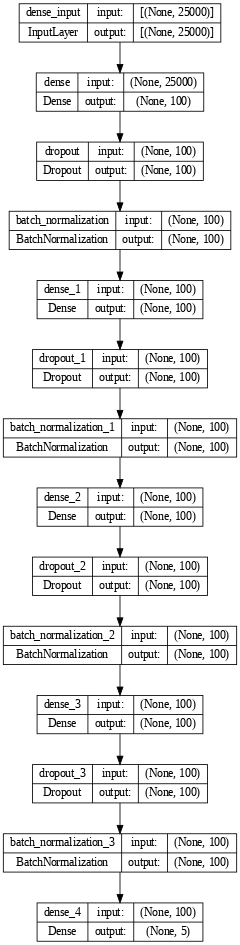

In [98]:
plot_model(model01, dpi=60, show_shapes=True)

###V.03 - OHE_3_GPT

In [ ]:
model01 = Sequential()
model01.add(Dense(512, input_dim=maxWordsCount, activation='relu'))
model01.add(Dense(256, activation='relu'))
model01.add(Dense(128, activation='relu'))
model01.add(Dense(5, activation='softmax'))

###V.04 - Em_1

In [ ]:
modelEmDC1D = Sequential()
modelEmDC1D.add(Embedding(maxWordsCount, 200, input_length=xLen))
modelEmDC1D.add(SpatialDropout1D(0.4))
modelEmDC1D.add(BatchNormalization())
modelEmDC1D.add(Conv1D(100, 5, activation="relu", padding='same'))
modelEmDC1D.add(MaxPooling1D(2))
modelEmDC1D.add(Dropout(0.50))
modelEmDC1D.add(BatchNormalization())
modelEmDC1D.add(GlobalMaxPooling1D())
modelEmDC1D.add(Flatten())
modelEmDC1D.add(Dense(5, activation='softmax'))

#Обучение

##Callback

In [22]:
class EarlyStoppingAtMinLoss(keras.callbacks.Callback):
    def __init__(self, patience=0):
        super(EarlyStoppingAtMinLoss, self).__init__()
        self.patience = patience
        # Атрибут best_weights для хранения весов, при которых достигнуто минимальное значение лосс-функции
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # Количество эпох, в течение которых значение лосс-фунции больше минимального
        self.wait = 0
        # Эпоха, на которой останавливается обучение
        self.stopped_epoch = 0
        # Лучшее текущее минимальное значение лосс-функции равно бесконечности
        self.best = np.Inf
        self.lr = round(float(tf.keras.backend.get_value(self.model.optimizer.learning_rate)), 3)

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get('val_loss')
        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            # Запись лучших весов (если текущие результаты лучше, т.е. меньше)
            self.best_weights = self.model.get_weights()
            self.best_epoch = epoch
        else:
            self.wait += 1
            if self.wait >= self.patience-20:
              if self.lr == 0.001:
                tf.keras.backend.set_value(self.model.optimizer.lr, round(self.lr/10, 4))
                self.lr = round(float(tf.keras.backend.get_value(self.model.optimizer.learning_rate)), 4)
                print("\nЭпоха %05d: Learning rate is %6.4f." % (epoch, self.lr))
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Восстановление весов моделей с конца лучшей эпохи.")
                self.model.set_weights(self.best_weights)


    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Эпоха %05d: ранняя остановка" % (self.stopped_epoch + 1))
        print("Эпоха с лучшим val_loss:  %05d" % (self.best_epoch + 1))
        print("val_loss:", self.best)

##Функции записи результатов

In [23]:
# Функция записи результатов обучения в txt-файл
def training_report(model_name, epochs, batch_size, optimizer_name, loss_name, metrics_name, val_accuracy_best, val_loss_min, val_epoches, lead_time):
  training_report = []
  training_report.append('epochs: '+ str(epochs))
  training_report.append('batch_size: '+ str(batch_size))
  training_report.append('optimizer: '+ str(optimizer_name))
  training_report.append('loss: '+ str(loss_name))
  training_report.append('metrics: '+ str(metrics_name))
  training_report.append('Точность лучшая: '+ str(round(val_accuracy_best, 4)))
  training_report.append('Ошибка наименьшая: '+ str(round(val_loss_min, 4)))
  training_report.append('Эпох пройдено: '+ str(val_epoches))
  training_report.append('Время обучения: '+ str(lead_time))

  # Открываем файл для записи
  with open('/content/drive/MyDrive/hacaton_X5/weights/'+ model_name +'_report.txt', 'w') as f:
      # Записываем каждый элемент списка в файл
      for item in training_report:
          f.write("%s\n" % item)

# Функция записи summary модели в txt-файл
def model_summary_save(model, model_name):
  with open('/content/drive/MyDrive/hacaton_X5/weights/' + model_name + '_summary.txt', 'w') as f:
      model.summary(print_fn=lambda x: f.write(x + '\n'))

##Запуск

Epoch 1/400
59/59 [==============================] - 5s 46ms/step - loss: 0.5582 - accuracy: 0.7947 - val_loss: 1.5277 - val_accuracy: 0.4387
Epoch 2/400
59/59 [==============================] - 2s 41ms/step - loss: 0.4926 - accuracy: 0.8209 - val_loss: 1.5981 - val_accuracy: 0.4140
Epoch 3/400
59/59 [==============================] - 2s 39ms/step - loss: 0.4538 - accuracy: 0.8345 - val_loss: 1.7288 - val_accuracy: 0.4227
Epoch 4/400
59/59 [==============================] - 4s 61ms/step - loss: 0.4030 - accuracy: 0.8583 - val_loss: 1.7423 - val_accuracy: 0.4233
Epoch 5/400
59/59 [==============================] - 4s 60ms/step - loss: 0.3721 - accuracy: 0.8701 - val_loss: 1.8350 - val_accuracy: 0.4313
Epoch 6/400
59/59 [==============================] - 2s 40ms/step - loss: 0.3373 - accuracy: 0.8824 - val_loss: 1.8347 - val_accuracy: 0.4373
Epoch 7/400
59/59 [==============================] - 2s 41ms/step - loss: 0.3199 - accuracy: 0.8840 - val_loss: 1.8987 - val_accuracy: 0.4347
Epoch 

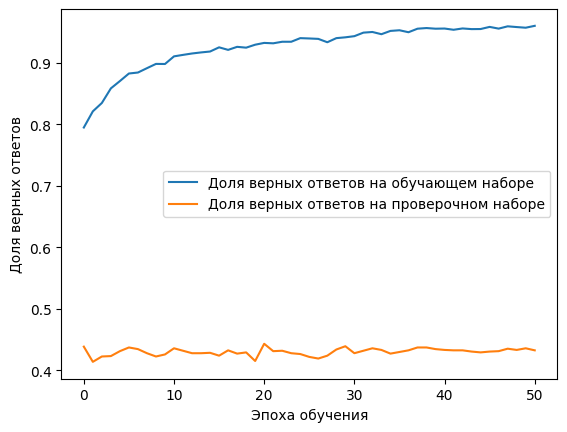

In [27]:
date_today = str(datetime.date.today())[-5:-3]+ str(datetime.date.today())[-2:]
type_nn = '01' # имя архитектуры
versia_arh = '1' # версия архитектуры
nom_nn = '4' # порядковый номер эксперимента на данной нейронке
epochs=400
batch_size=128
optimizer_name = 'adam'
loss_name ='categorical_crossentropy'
metrics_name = 'accuracy'
# validation_split=0.15
ErStAtMinLoss = 50 #сколько ждём эпох в callback'е

# имя эксперимента
model_name = f'{date_today}_model{type_nn}_v.{versia_arh}_ep{epochs}_bs{batch_size}_{nom_nn}'

model01.compile(optimizer=optimizer_name,
              loss=loss_name,
              metrics=[metrics_name])

# Обучаем сеть на выборке
cur_time = time.time() # Засекаем время

history = model01.fit(xTrain01,
                    yTrain01,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(xTest01, yTest01), callbacks=[EarlyStoppingAtMinLoss(ErStAtMinLoss)], verbose=1, shuffle=True)

# Сохраняем веса модели и отчёт по обучению
# model01.save_weights(f'/content/drive/MyDrive/hacaton_X5/weights/{model_name}.h5')
model01.save(f'/content/drive/MyDrive/hacaton_X5/weights/{model_name}_all.h5')

val_accuracy_best = max(history.history['val_accuracy']) #Точность лучшая
val_loss_min = min(history.history['val_loss']) #Ошибка наименьшая
val_epoches = len(history.history['loss']) #Эпох пройдено
lead_time = str(round(time.time() - cur_time, 2)) + 'c' #Время выполнения
print('Время выполнения: ', lead_time)

training_report(model_name, epochs, batch_size, optimizer_name, loss_name, metrics_name, val_accuracy_best, val_loss_min, val_epoches, lead_time)
print('Лучшая точность:', max(history.history['val_accuracy']))
print('Наименьшая ошибка:', min(history.history['val_loss']))

# Выводим графики
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()
beep()

#Predict

In [128]:
# Загрузка архитектуры и весов нейронной сети
# model = load_model('/content/drive/MyDrive/hacaton_X5/weights/0909_model01_v.1_ep400_bs128_2_all.h5')

# # Загружаем файлы tokenizer'а и обучающую базу
# with open('/content/drive/MyDrive/hacaton_X5/output/tokenizer.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle)

# Загружаем файл с отзывами
shop_reviews = pd.read_excel('/content/drive/MyDrive/hacaton_X5/weights/shops_reviews_verif.xlsx')

In [150]:
shops_reviews_verif.reset_index(inplace=True)
shops_reviews_verif.drop('index', axis=1)

,rate,text,date,id
0,1,"Тесно, грязно, на полках свалка, найти актуаль...",2020-01-23,1035579373
1,1,"Отрицательно отношусь к данной сети, кроме све...",2023-04-26,227040508671
2,1,За мелкие яйца с1 синявинские(напротив них был...,2023-05-09,227040508671
3,1,"Не знаю, как зовут этого персонажа, ходит по р...",2022-12-24,227040508671
4,1,"Отвратный магазин, на кассе сидит полусонная к...",2022-02-03,227040508671
...,...,...,...,...
335,5,Чистый магазин.,2021-06-02,213564317684
336,5,Все очень понравилось!,2020-10-29,213564317684
337,5,Чисто,2021-08-01,213564317684
338,5,Продавцы очень любезны,2020-10-03,213564317684


In [151]:
# Преобразуем верификационную выборку
shop_reviews_text = shop_reviews.text.tolist()
testFinWordIndexes = tokenizer.texts_to_sequences(shop_reviews_text) # Обучающие тесты в индексы

test = np.empty((0, maxWordsCount)) # Обучающая
for i in range(len(testFinWordIndexes)):
  arr_token = tokenizer.sequences_to_matrix(np.array([testFinWordIndexes[i]]).tolist())
  test = np.concatenate((test, arr_token), axis=0)
beep()

In [152]:
#Функция отчёта по предсказаниям
def recognizeMultiClass(model, test, modelName):
  print("НЕЙРОНКА: ", modelName)
  print()

  totalSumRec = 0 # Сумма всех правильных ответов

  #Проходим по всем классам
  for i in range(len(shops_reviews_verif)):
    #Получаем результаты распознавания класса по блокам слов длины xLen
    currPred = model.predict(test[[i]])
    #Определяем номер распознанного класса для каждохо блока слов длины xLen
    currOut = np.argmax(currPred, axis=1)
    currOut = currOut +1

    #Выводим результаты распознавания по текущему классу
    isRecognized = "Это НЕПРАВИЛЬНЫЙ ответ!"
    if (currOut == shops_reviews_verif.rate[i]):
      isRecognized = "Это ПРАВИЛЬНЫЙ ответ!"
      totalSumRec +=1
    str1 = 'Класс: ' + str(shops_reviews_verif.rate[i]) + " сеть отнесла к классу: " + str(currOut)
    print(str1, " " * (55-len(str1)), isRecognized, sep='')

  #Выводим средний процент распознавания по всем классам вместе
  print()
  sumCount = 0
  for i in range(len(shops_reviews_verif)):
    sumCount += len(test[[i]])
  print("Средний процент распознавания ", int(100*totalSumRec/sumCount), "%", sep='')

  print()

  return totalSumRec/sumCount

In [153]:
pred = recognizeMultiClass(model, test, "BOW")

НЕЙРОНКА:  BOW

1/1 [==============================] - 0s 27ms/step
Класс: 1 сеть отнесла к классу: [2]                    Это НЕПРАВИЛЬНЫЙ ответ!
1/1 [==============================] - 0s 25ms/step
Класс: 1 сеть отнесла к классу: [3]                    Это НЕПРАВИЛЬНЫЙ ответ!
1/1 [==============================] - 0s 31ms/step
Класс: 1 сеть отнесла к классу: [1]                    Это ПРАВИЛЬНЫЙ ответ!
1/1 [==============================] - 0s 25ms/step
Класс: 1 сеть отнесла к классу: [2]                    Это НЕПРАВИЛЬНЫЙ ответ!
1/1 [==============================] - 0s 27ms/step
Класс: 1 сеть отнесла к классу: [2]                    Это НЕПРАВИЛЬНЫЙ ответ!
1/1 [==============================] - 0s 34ms/step
Класс: 1 сеть отнесла к классу: [1]                    Это ПРАВИЛЬНЫЙ ответ!
1/1 [==============================] - 0s 26ms/step
Класс: 1 сеть отнесла к классу: [2]                    Это НЕПРАВИЛЬНЫЙ ответ!
1/1 [==============================] - 0s 30ms/step
Класс: 1 сеть отнес

In [92]:
#Собираем список для подачи в сервис
prediction = []
id_address = pd.read_excel('/content/drive/MyDrive/hacaton_X5/database/shops_rates.xlsx', usecols=['id', 'address'])
shop_id = shop_reviews.id[0] #Берём id магазина
shop_address = id_address.address[id_address.index[id_address.id == shop_id][0]] #Берём адрес по id
prediction.append([shop_id, shop_address])

#Проходим по всем классам
for i in range(len(shops_reviews)):
  #Получаем результаты распознавания класса по блокам слов длины xLen
  currPred = model.predict(test[[i]])
  #Определяем номер распознанного класса для каждохо блока слов длины xLen
  currOut = np.argmax(currPred, axis=1)
  currOut = currOut +1
  prediction.append([shop_reviews.text[i], currOut])

1/1 [==============================] - 0s 21ms/step


In [93]:
prediction

[[189979809983, 'Невский просп., 146, Нк1-, помещение 1'],
 ['В пятëрочках была организована акция "остров сокровищ".Я собрал всю коллекцию монет, но не могу купить альбом. Монеты теперь лежат в мешочке. Если бы я знал то что не возможно купить альбом я даже не собирал бы коллекцию. \nПрошу мне помочь купить альбом! Так как там в альбоме информация о каждой монете. У меня попались две монеты" 5" я зарегистрировал, но призов так и нет. Если Вы проводите акции то доводите их до конца и не обманывайте. ',
  array([1])],
 ['Казалось бы, центр города, а доставка работает ужасно! Задержали доставку почти на час, дома уже никого не было, пришлось отменить заказ. ',
  array([2])],
 ['Не очень, в магазине работала всего одна касса в которой потерял много времени, а также один сотрудник был не самый грамотный. Единственные плюсы цены и ассортимент. ',
  array([3])],
 ['большой для центра города зал, все хорошо и с ассортиментом и с чистотой, но есть огромная проблема с кассами, с кассиром всего 